# Lab4 exercises 1

### Intro
In this laboratory, you will build your own version of the K-Nearest Neighbors algorithm (a.k.a. KNN) using the NumPy library.

#### Preliminary steps

In [1]:
!test -e iris.csv || wget "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" -O iris.csv

In [2]:
!test -e mnist_test.csv || wget "https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/mnist_test.csv" -O mnist_test.csv

#### KNN design and implementation
As you might remember from Lab. 1, the Iris dataset collects the measurements of different Iris flowers, and each data point is associated with a Iris species (Setosa, Versicolor, or Virginica). In this exercise, you will implement your own version of the the K-Nearest Neighbors algorithm, and you will use it to assign a Iris species (i.e. a label) to flowers whose species is unknown.
The KNN algorithm is straightforward. Suppose that some measurements (i.e. records) and their relative species are known in advance. Then, whenever we want to label a new flower, we look at the K most similar points (a.k.a. neighbors) and assign a label accordingly. The simplest solution is using a majority voting scheme: if the majority of the neighbors votes for a label, we will go for it. This approach is naive only at first sight: the local similarity assumed by KNN happens to be roughly true. Even though this reasoning does not generalize well1, the KNN provides a valid baseline for your tasks.

#### Exericse 1.1.1
Load the Iris dataset

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("iris.csv", header=None)
print(f"Loaded {len(df)} rows")
df[:5] # df.values return a numpy array

Loaded 150 rows


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Exercise 1.1.2 and 1.1.3
Let’s identify a portion of our data for which we will try to guess the species. Randomly select 20% of the records and store the first four columns (i.e. the features representing each flower) into a two-dimensional numpy array of shape N × C, you can call it X_test.
For the same records, store the last column (i.e. the one with the species values) into another array, namely y_test. This is the data that will be used to test the accuracy of your KNN implementation and its correct functioning (i.e. the testing data).

Store the remaining 80% of the records in the same way. In this case, use the names X_train and y_train for the arrays. This is the data that your model will use as ground-truth knowledge (i.e. the training data).

In [4]:
X = df.values[:, :4].astype(float) # all rows (:), columns 0 -> 3 (:4)
y = df.values[:, 4] # all rows (:), 4th column (4)
X.shape, y.shape

((150, 4), (150,))

In [5]:
# Create the mask to select only 80% of the dataset
mask = np.array([True] * 120 + [False] * 30)
np.random.shuffle(mask)
mask

array([ True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False, False, False, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,

In [6]:
X_train = X[mask]
X_test = X[~mask]

y_train = y[mask]
y_test = y[~mask]
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((120, 4), (30, 4), (120,), (30,))

#### Exercise 1.1.4
Focus now on the KNN technique. You can find a thorough explanation of the algorithm on the course slides on classification techniques (slides [117,125]).
Starting from the next laboratory, you will use the scikit-learn package. Many of its functionalities are exposed via an object-oriented interface. With this paradigm in mind, implement now the KNN algorithm and expose it as a Python class. The bare skeleton of your class should look like this (you are free to add as many methods as you want):

In [7]:
# (class after edits)
class KNearestNeighbors:
    def __init__(self, k, distance_metric="euclidean"):
        self.k = k
        self.distance_metric = distance_metric
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        pass

#### Exercise 1.1.5
To identify the K closest points, or neighbors, a notion of distance is required. Your implementation must support three different distance definitions. Given two n-dimensional points p = (p1, p2, . . . , pn) and q = (q1, q2, . . . , qn), the euclidean distance is defined as

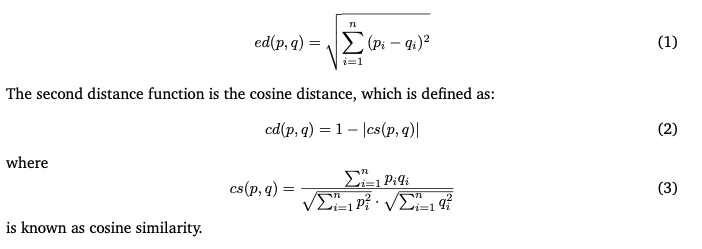
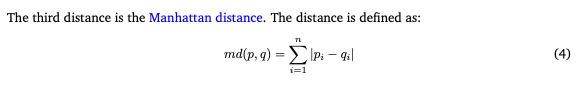

In [8]:
class KNearestNeighbors:
    def __init__(self, k, distance_metric="euclidean"):
        self.k = k
        self.distance_metric = distance_metric
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_train_reshaped = np.expand_dims(self.X_train, 1)
        self.X_train_norm = ((self.X_train**2).sum(axis=1)**.5).reshape(-1,1)

    def _euclidean(self, X_test):
        X_diff = self.X_train_reshaped - X_test
        dist_matrix = ((X_diff**2).sum(axis=2))**.5
        return dist_matrix

    def _cosine(self, X_test):
        X_test_norm = ((X_test**2).sum(axis=1)**.5)
        dot_prods = X_train @ X_test.T 
        dist_matrix = 1 - abs(dot_prods / self.X_train_norm.reshape(-1,1) / X_test_norm)
        return dist_matrix

    def _manhattan(self, X_test):
        X_diff = self.X_train_reshaped - X_test
        dist_matrix = abs(X_diff).sum(axis=2)
        return dist_matrix

    
    def predict(self, X_test):
        pass

#### Exercise 1.1.6
Implement the predict method. The function receives as input a numpy array with N rows and C columns, corresponding to N flowers. The method assigns one of the three Iris species to each row using the KNN algorithm, and returns them as a numpy array. For the actual implementation, apply the identify K neighbors using the distance specified by the parameters k and distance passed to the constructor.
Then, assign the label using a majority voting scheme

In [9]:
from collections import Counter
class KNearestNeighbors:
    def __init__(self, k, distance_metric="euclidean", weights="uniform"):
        self.k = k
        self.distance_metric = distance_metric
        self.weights = weights
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_train_reshaped = np.expand_dims(self.X_train, 1)
        self.X_train_norm = ((self.X_train**2).sum(axis=1)**.5).reshape(-1,1)

    def _euclidean(self, X_test):
        X_diff = self.X_train_reshaped - X_test
        dist_matrix = ((X_diff**2).sum(axis=2))**.5
        return dist_matrix

    def _cosine(self, X_test):
        X_test_norm = ((X_test**2).sum(axis=1)**.5).T
        dot_prods = X_train @ X_test.T 
        dist_matrix = 1 - abs(dot_prods / self.X_train_norm.reshape(-1,1) / X_test_norm)
        return dist_matrix

    def _manhattan(self, X_test):
        X_diff = self.X_train_reshaped - X_test
        dist_matrix = abs(X_diff).sum(axis=2)
        return dist_matrix

    def _majority_voting(self, votes):
        count = Counter(votes)
        return count.most_common(1)[0][0] # most_common(n) returns a list with the n most recurring votes (n=1 -> top vote)

    def _weighted_majority_voting(self, votes, weights):
        # we now compute `count` as a sum of weights
        # (no longer through Counter -- which effectively
        # weighted all votes as "1")
        count = defaultdict(lambda: 0)
        for vote, weight in zip(votes, weights):
            count[vote] += weight
        return max(count.items(), key=lambda x: x[1])[0] # return the max value (use a custom key extractor)
    
    def predict(self, X_test):
        if self.distance_metric == "euclidean":
            dist_matrix = self._euclidean(X_test)
        elif self.distance_metric == "cosine":
            dist_matrix = self._cosine(X_test)
        elif self.distance_metric == "manhattan":
            dist_matrix = self._manhattan(X_test)
        else:
            raise Exception("Unknown distance metric")
        
        knn = dist_matrix.argsort(axis=0)[:self.k, :].T
        if self.weights == "uniform":
            y_pred = np.array([ self._majority_voting(self.y_train[knn][i]) for i in range(len(self.y_train[knn])) ])
        elif self.weights == "distance":
            weights = 1/(np.take_along_axis(dist_matrix, knn.T, 0)+1e-5)
            y_pred = np.array([ self._weighted_majority_voting(y_train[knn][i], weights[:, i]) for i in range(len(y_train[knn])) ])
        else:
            raise Exception("Unknown weights")
        return y_pred

In [10]:
knn_model = KNearestNeighbors(3, "cosine")
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_pred

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica'], dtype='<U15')

#### Exercise 1.1.7
Now let’s fit the KNN model with the X_train and y_train data. Then, try to use your KNN model
to predict the species for each record in X_test and store them in a nupy array called y_pred.
Check how many Iris species in the array y_pred have been guessed correctly with respect to the ones in y_test.

In [11]:
# This function leverages the fact that booleans (the output of the equality check) are stored as 0's and 1's in numpy 
# (therefore, using sum() on a boolean array returns the number of True values).

def accuracy_score(y_true, y_pred):
    return (y_true==y_pred).sum()/len(y_true)

In [12]:
accuracy_score(y_test, y_pred)

1.0